## Music Classification
The main features that will be used to determine the similarity between two songs will be temp of the songs and when beats occur, the percussive rythm, and the sequence of notes played

In [1]:
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [3]:
from __future__ import print_function
import librosa

# 1. Load the audio as a waveform `y`, store the sampling rate as `sr`
y, sr = librosa.load("music files/2Pac - can't c me.wav")

In [4]:
print("Number of Samples: {:d}".format(y.shape[0]))
print("Sampling Rate is: {:d} samples/sec".format(sr))

Number of Samples: 7293072
Sampling Rate is: 22050 samples/sec


## Extract Tempo and Beat Instances

In [5]:
# 2. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 3. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

#print('Saving output to beat_times.csv')
#librosa.output.times_csv('beat_times.csv', beat_times)

Estimated tempo: 95.70 beats per minute


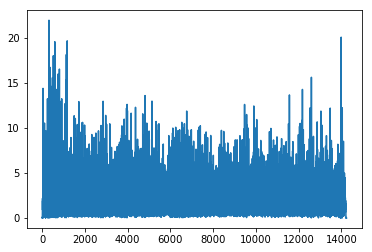

In [6]:
#4. Rhythm features - Tempogram

hop_length = 512
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
plt.plot(oenv, label='Onset strength')

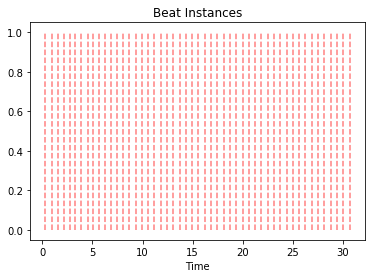

In [7]:
plt.vlines(beat_times[:50], 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Beats')
plt.title("Beat Instances")
plt.xlabel("Time")

### Extract Percussive Component 

In [8]:
 # Extract harmonic and percussive components
 y_harmonic, y_percussive = librosa.effects.hpss(y[500000:1000000], margin=(1.0,5.0))

In [10]:
import IPython.display as ipd

#Play a bit of the song
ipd.Audio(y[500000:1000000], rate=sr) 

In [12]:
#Play the percussive component
ipd.Audio(y_percussive, rate=sr) 

### Extract Chroma Data

In [15]:
import librosa.display
chroma_cens = librosa.feature.chroma_cens(y=y[500000:600000], sr=sr)
chroma_cq = librosa.feature.chroma_cqt(y=y[500000:600000], sr=sr)

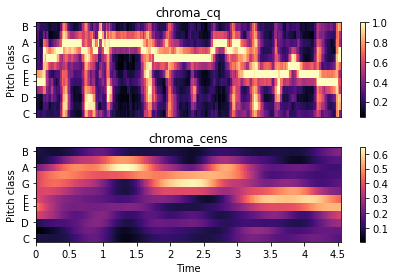

In [16]:
plt.figure()
plt.subplot(2,1,1)
librosa.display.specshow(chroma_cq, y_axis='chroma')
plt.title('chroma_cq')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.title('chroma_cens')
plt.colorbar()
plt.tight_layout()

## Repeat to a Few Frames of Training Data
First we load the expected song similarity rating that is from 0-4. The rows and columns of the excel file are the names of the songs used. The value at row n and column m is the rating of how similar song n and song m are to each other. To eliminate repeated values and song pairs only the top diagonal of the matrix has values. The song similary between song 1 and song 2 is the same between song 2 and song 1 so there is nothing new to gain.

In [17]:
import pandas as pd
df = pd.read_excel('Song Correlation.xlsx')

In [18]:
df.head()

Nirvana - Heart Shaped Box  \
Nirvana - Heart Shaped Box                                  4.0   
Alice in Chains - Rooster                                   NaN   
Chic - Le Freak                                             NaN   
Wild Cherry - Play that Funky Music                         NaN   
Snoop Dogg - who am i                                       NaN   

                                     Alice in Chains - Rooster  \
Nirvana - Heart Shaped Box                                 4.0   
Alice in Chains - Rooster                                  4.0   
Chic - Le Freak                                            NaN   
Wild Cherry - Play that Funky Music                        NaN   
Snoop Dogg - who am i                                      NaN   

                                     Chic - Le Freak  \
Nirvana - Heart Shaped Box                       2.0   
Alice in Chains - Rooster                        2.0   
Chic - Le Freak                                  4.0   
Wild Cherry - Play that Funky Music              NaN   
Snoop Dogg - who am i                            NaN   

                                     Wild Cherry - Play that Funky Music  \
Nirvana - Heart Shaped Box                                           2.0   
Alice in Chains - Rooster                                            2.0   
Chic - Le Freak                                                      4.0   
Wild Cherry - Play that Funky Music                                  4.0   
Snoop Dogg - who am i                                                NaN   

                                     Snoop Dogg - who am i  2Pac - can't c me  \
Nirvana - Heart Shaped Box                             0.0                0.0   
Alice in Chains - Rooster                              0.0                0.0   
Chic - Le Freak                                        1.0                0.0   
Wild Cherry - Play that Funky Music                    0.0                0.0   
Snoop Dogg - who am i                                  4.0                4.0   

                                     Chicago - 25 or 6 to 4  \
Nirvana - Heart Shaped Box                              2.0   
Alice in Chains - Rooster                               2.0   
Chic - Le Freak                                         1.0   
Wild Cherry - Play that Funky Music                     2.0   
Snoop Dogg - who am i                                   0.0   

                                     Green Day - Brain Stew  Beck G - Mayores  \
Nirvana - Heart Shaped Box                              3.0               0.0   
Alice in Chains - Rooster                               3.0               0.0   
Chic - Le Freak                                         1.0               1.0   
Wild Cherry - Play that Funky Music                     1.0               1.0   
Snoop Dogg - who am i                                   0.0               1.0   

                                     Maluma - Felices los 4  
Nirvana - Heart Shaped Box                                0  
Alice in Chains - Rooster                                 0  
Chic - Le Freak                                           1  
Wild Cherry - Play that Funky Music                       1  
Snoop Dogg - who am i                                     0

In [19]:
df.columns.values

array(['Nirvana - Heart Shaped Box', 'Alice in Chains - Rooster',
       'Chic - Le Freak', 'Wild Cherry - Play that Funky Music',
       'Snoop Dogg - who am i', "2Pac - can't c me",
       'Chicago - 25 or 6 to 4', 'Green Day - Brain Stew',
       'Beck G - Mayores', 'Maluma - Felices los 4'], dtype=object)

In [20]:
# Frame size 
nfft = 22050

In [21]:
# Function to return a vector of song parameters
def getx(song):
    # load song
    y, sr = librosa.load("music files/" + song + ".wav")
    
    # take frames to do calculations of the middle of a song, after any intros
    nframe = 60
    ycrop = y[nframe*nfft:(nframe+40)*nfft]
    
    # tempo features. Beat_frames are the samples where a strong beat occurs
    tempo, beat_frames = librosa.beat.beat_track(y=ycrop, sr=sr)
    # array beats is created so each song has the same length for x
    # beats = 0 unless a strong beat occurs at samples given from beat_frames
    beats = np.zeros((ycrop.shape))  
    beats[beat_frames] = 1            
    
    # percussive features
    y_percussive = librosa.effects.hpss(ycrop, margin=(1.0,5.0))[1]
    
    # chroma features
    chroma_cq = librosa.feature.chroma_cqt(y=ycrop, sr=sr)
    chroma_cq = np.ravel(chroma_cq) # flatten the 12 rows

    # predictor
    xi = np.hstack([sr, tempo, beats, y_percussive, chroma_cq])
    
    return xi
    

In [23]:
# Load all songs and get song parameters
x = []
for i, song in enumerate(df.columns.values):
    xi = getx(song)
    x.append(xi)
    

In [36]:
# Turn to array
X = np.array(x)

In [78]:
# Pickle to save X
import pickle

with open("X.p", "wb") as fp:
    pickle.dump(X,fp)

In [79]:
# Load X
with open("X.p", "rb") as fp:
    X = pickle.load(fp)

In [37]:
# Y matrix listing likeness values (just extracted values from excel, not correct for neural network input)

y = np.array(df)
print(y)

[[  4.   4.   2.   2.   0.   0.   2.   3.   0.   0.]
 [ nan   4.   2.   2.   0.   0.   2.   3.   0.   0.]
 [ nan  nan   4.   4.   1.   0.   1.   1.   1.   1.]
 [ nan  nan  nan   4.   0.   0.   2.   1.   1.   1.]
 [ nan  nan  nan  nan   4.   4.   0.   0.   1.   0.]
 [ nan  nan  nan  nan  nan   4.   0.   0.   0.   0.]
 [ nan  nan  nan  nan  nan  nan   4.   3.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan   4.   0.   0.]
 [ nan  nan  nan  nan  nan  nan  nan  nan   4.   4.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan   4.]]


In [98]:
# Turn y into a vector

i = 0
j = 0
n = y.shape[0] #number of rows/columns
ind = 0

yvect = np.zeros((np.sum(range(n+1)),1)) 
order = np.zeros((np.sum(range(n+1)),2))

for i in range(n):
    for j in range(i,n):
        yvect[ind] = y[i,j]
        
        # to keep track of which song #s correspond to yvect indices
        order[ind] = np.array([i,j])
        ind = ind + 1

In [99]:
# Example of yvect and order

print('Target variable and corresponding song pair')
print('\ty\t\tsongs')
for i in range(8,14):
    print('\t%d'%yvect[i]+'\t\t%d, %d'%(order[i,0],order[i,1]))

Target variable and corresponding song pair
	y		songs
	0		0, 8
	0		0, 9
	4		1, 1
	2		1, 2
	2		1, 3
	0		1, 4


## Generating the predictors
The matrix X contains all the musical features of each song. y is the target variable for each possible song pair that is non-repeating. Therefore each corresponding predictor vector should contain the features from the two songs of that pair. For example, the song similary between song 1 and song 2 would have a predictor vector of both song 1 and 2 features stacked.

In [100]:
# Generate the final predictor vectors based on the song pairs

ncomb = yvect.shape[0] #total number of non repeated song pairs
Xcomb = np.zeros((ncomb, X.shape[1]*2))
for i in range(order.shape[0]):
    
    # Xcomb takes the features from the two songs given by 'order'
    Xcomb[i] = np.hstack((X[int(order[i,0]),:],  X[int(order[i,1]),:]))

In [75]:
# Keras libraries

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [103]:
# Data Splitting

ntr = round((2/3)*ncomb)
Iperm = np.random.permutation(ncomb) #random permutation of all X sample rows
train = Iperm[:ntr]
test = Iperm[ntr:]
Xtr = Xcomb[train,:]
ytr = yvect[train]
Xts = Xcomb[test,:]
yts = yvect[test]

In [106]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [152]:
# Keras Clear Session
import keras.backend as K
K.clear_session()

In [153]:
# Neural Network Model

nin = Xtr.shape[1]
nh = 10
nout = 5 
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation = 'softmax',name='output'))

In [154]:
# Print Model Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 10)                35693570  
_________________________________________________________________
output (Dense)               (None, 5)                 55        
Total params: 35,693,625
Trainable params: 35,693,625
Non-trainable params: 0
_________________________________________________________________


In [155]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.loss = []
        self.val_acc = []
 
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('val_acc') to the val_acc list
        self.val_acc.append(logs.get('val_acc'))

# Create an instance of the history callback
history_cb = LossHistory()

In [156]:
from keras import optimizers

opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [157]:
model.fit(Xtr, ytr, epochs=10, batch_size=100, validation_data=(Xts,yts), callbacks=[history_cb])

Train on 37 samples, validate on 18 samples
Epoch 1/10
37/37 [==============================] - 7s 177ms/step - loss: 2.2899 - acc: 0.1351 - val_loss: 1.8051 - val_acc: 0.1111
Epoch 2/10
37/37 [==============================] - 4s 96ms/step - loss: 1.8508 - acc: 0.1351 - val_loss: 1.8000 - val_acc: 0.1111
Epoch 3/10
37/37 [==============================] - 4s 103ms/step - loss: 1.8459 - acc: 0.1351 - val_loss: 1.7950 - val_acc: 0.1111
Epoch 4/10
37/37 [==============================] - 4s 96ms/step - loss: 1.8412 - acc: 0.1351 - val_loss: 1.7901 - val_acc: 0.1111
Epoch 5/10
37/37 [==============================] - 4s 96ms/step - loss: 1.8365 - acc: 0.1351 - val_loss: 1.7851 - val_acc: 0.1111
Epoch 6/10
37/37 [==============================] - 4s 95ms/step - loss: 1.8318 - acc: 0.1351 - val_loss: 1.7804 - val_acc: 0.1111
Epoch 7/10
37/37 [==============================] - 4s 97ms/step - loss: 1.8272 - acc: 0.1351 - val_loss: 1.7755 - val_acc: 0.1111
Epoch 8/10
37/37 [===================

In [59]:
   
    
    # testing stuff
    
    y, sr = librosa.load("music files/Nirvana -  Heart Shaped Box.wav")
    
    # Convert to floating point values so that compuations below do not overflow
y = y.astype(float)
    
    # take 2nd frame to do calculations of the middle of a song, after any intros
    # Frame size
nfft = 22050
    nframe = 2
    ycrop = y[nframe*nfft:(nframe+1)*nfft]
    


    

    



In [61]:
nfft = 22050
nframe = 60
ycrop = y[nframe*nfft:(nframe+40)*nfft]

In [62]:
    # tempo features
    tempo, beat_frames = librosa.beat.beat_track(y=ycrop, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)

In [63]:
    
    # percussive features
    y_percussive = librosa.effects.hpss(ycrop, margin=(1.0,5.0))[1]

In [58]:
print(y.shape)
print(y)
import IPython.display as ipd
print(y.shape)
#Play a bit of the song
ipd.Audio(y[60*nfft:100*nfft], rate=sr) 
#plt.plot(y[60*nfft:120*nfft])

(6266512,)
[ 0.  0.  0. ...,  0.  0.  0.]
(6266512,)


In [64]:
    # chroma features
    chroma_cq = librosa.feature.chroma_cqt(y=ycrop, sr=sr)

In [85]:
    print(tempo)
    print(beat_times.shape)
    print(y_percussive.shape)
    chroma_cq = np.ravel(chroma_cq)
    print(chroma_cq.shape)
    xtst = np.hstack([tempo, beat_times, y_percussive, chroma_cq])
    print(xtst.shape)


99.3840144231
(66,)
(882000,)
(20676,)
(902743,)


In [ ]:
val = []
for i, song in enumerate(df.columns.values):